In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tensorflow_probability as tfp
tfd = tfp.distributions
from distributions import *
from etas import *
from model import *

sns.set_style("whitegrid")

### Functions

In [27]:
def cmp_dist(model: Model,
             seq: np.ndarray,
             start: int,
             ylim: tuple[float, float] = (0, 1)
) -> None:
    """Compare ETAS and RECAST distributions."""

    sub_seq = seq[:start]
    t = sub_seq[:, 0]
    m = sub_seq[:, 1]

    recast_dist = model.predict(t, m, 1, True)[1][0]
    etas_dist = ETAS(t, m)

    fig, axes = plt.subplots(2, 1, sharex="col", sharey="col", figsize=(6, 3))
    x = np.linspace(0, 3, 1000)
    axes[0].plot(x, recast_dist.prob(x), label="RECAST")
    axes[1].plot(x, etas_dist.prob(x), label="ETAS")
    axes[1].set_ylim(ylim)

    plt.show()

In [4]:
def plot_etas_seq(seq: pd.DataFrame,
                  n: int = 0,
                  dpi: Optional[int] = None
) -> None:
    """Print the ETAS given sequence and the n first events in magnitude."""
    
    fig, ax = plt.subplots(figsize=(6, 4), dpi=dpi)

    ax.plot(seq.time, seq.index + 1)
    high_mags_idx = seq.magnitude.sort_values(ascending=False).index[:n]
    for idx in high_mags_idx:
        t = seq.time.iloc[idx]
        m = seq.magnitude.iloc[idx]
        ax.scatter(t, idx + 1, label=f"{m:.2f}", marker=".", s=100)
        ax.vlines(t, 0, idx + 1, linestyle="--", alpha=0.5, colors="black")

    if n:
        ax.legend(loc="upper left", ncol=2)

    plt.show()

In [5]:
def get_seq(generated_data: np.ndarray,
            seq_lengths: np.ndarray,
            i: int
) -> pd.DataFrame:
    """Return a pandas dataframe holding the generated data."""
    
    arrival_times = generated_data[i, :seq_lengths[i], 0]
    magnitudes = generated_data[i, :seq_lengths[i], 1]
    seq = pd.DataFrame({"time": arrival_times, "magnitude": magnitudes})
    return seq

In [6]:
def plot_seqs(seqs: list[np.ndarray]):
    for seq in seqs:
        plt.plot(seq[:, 0], np.cumsum(np.ones(seq.shape[0])))
    plt.show()

In [7]:
def cumsum(arr: np.ndarray) -> np.ndarray:
    return np.cumsum(np.ones_like(arr))

In [21]:
def predict_and_plot(model: Model,
                     seq: np.ndarray,
                     n_before: int,
                     n_after: Optional[int] = None,
                     dpi: Optional[int] = None
) -> np.ndarray:
    """Make predictions and return the new outputted sequence."""

    n_preds = n_after if n_after else n_before

    past_seq = seq[:-n_before]

    t = past_seq[:, 0]
    m = past_seq[:, 1]
    preds = model.predict(t, m, n_preds)
    t_preds = preds[:, 0]
    m_preds = preds[:, 1]
    seq_size = seq.shape[0]
    last_idx_target = min(seq_size - 1, seq_size - n_before + n_preds)
    t_targets = seq[-n_before:last_idx_target, 0]

    fig, ax = plt.subplots(dpi=dpi)
    ax.plot(t, cumsum(t), label="Past sequence")
    ax.plot(t_preds, t.size + cumsum(t_preds), label="Predictions", alpha=0.6)
    ax.plot(t_targets, t.size + cumsum(t_targets), label="Targets", alpha=0.6)
    ax.axhline(y=t.size, linestyle="--", c="black", alpha=0.7)
    ax.legend()
    plt.show()

    new_seq = np.concatenate([past_seq[:, :2], preds], 0)
    return new_seq

### Generating sequences

In [3]:
seq = etas(t_end=2000)
frame = pd.DataFrame(seq, columns=["time", "magnitude", "parent"])
frame.tail()

,time,magnitude,parent
6174,1998.855957,1.25,-1.0
6175,1998.855957,0.30,6174.0
6176,1998.870972,0.11,6172.0
6177,1999.082031,0.08,-1.0
6178,1999.708008,0.15,-1.0


In [4]:
frame.time

0          0.542000
1          0.960000
2          0.960000
3          0.960000
4          3.124000
           ...     
6174    1998.855957
6175    1998.855957
6176    1998.870972
6177    1999.082031
6178    1999.708008
Name: time, Length: 6179, dtype: float32

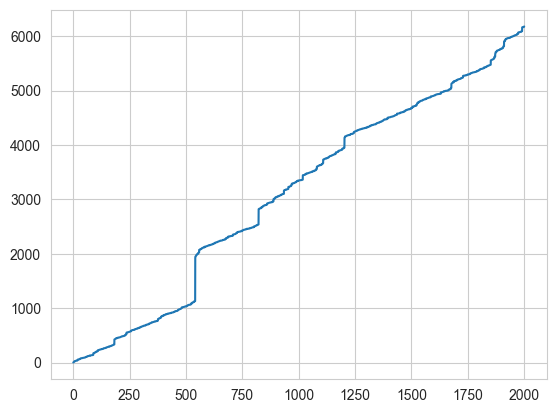

In [5]:
plt.plot(frame.time, frame.index + 1)
plt.show()

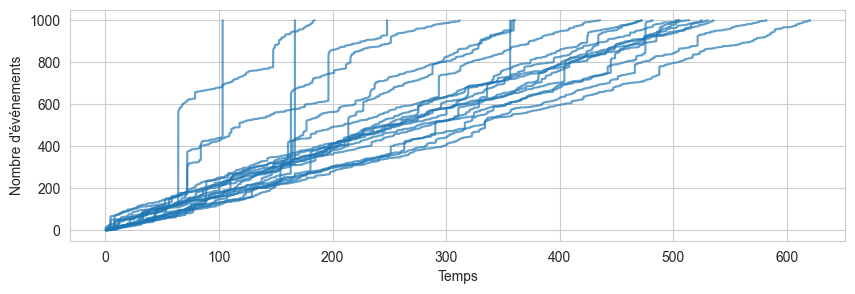

In [193]:
seqs = []
num_seqs = 20
plt.figure(figsize=(10, 3))
for k in range(num_seqs):
    seq = etas(max_len=1000)
    seqs.append(seq)
    plt.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1), c="C0", alpha=0.7)
    print("Generating sequences:", k + 1, "\r", end="")
plt.xlabel("Temps")
plt.ylabel("Nombre d'événements")
plt.savefig("batch_etas.png", bbox_inches="tight", dpi=150)

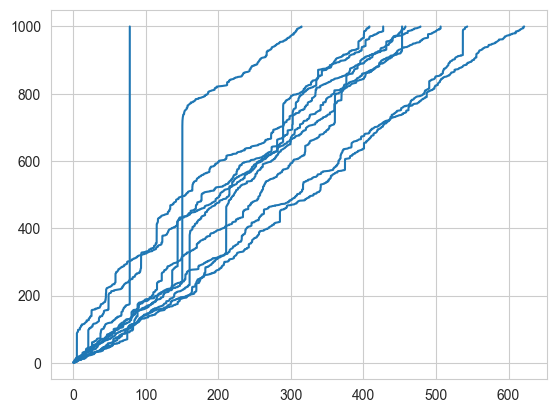

In [93]:
seqs = []
max_len = 1000
num_seqs = 10
for k in range(num_seqs):
    seq = etas(max_len=max_len)
    seqs.append(seq)
    plt.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1), c="C0")
    print("Generating sequences:", k + 1, "\r", end="")
plt.show()

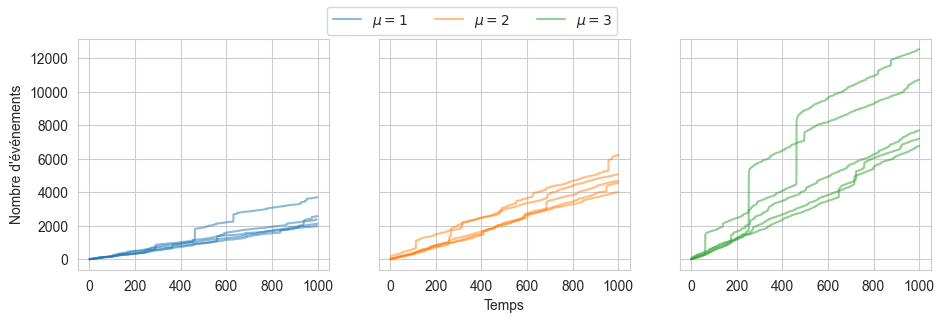

In [110]:
mu = [1, 2, 3]

fig, axes = plt.subplots(1, 3, sharey="row", figsize=(11, 3))

for i, (m, ax) in enumerate(zip(mu, axes)):
    for j in range(5):
        label=f"$\\mu = {m}$" if j == 0 else None
        seq = etas(t_end=1000, mu=m)
        ax.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1), label=label, c=f"C{i}", alpha=0.5)

axes[0].set_ylabel("Nombre d'événements")
axes[1].set_xlabel("Temps")

fig.legend(loc="upper center", ncol=3)
plt.savefig("mu_etas.png", bbox_inches="tight", dpi=150)

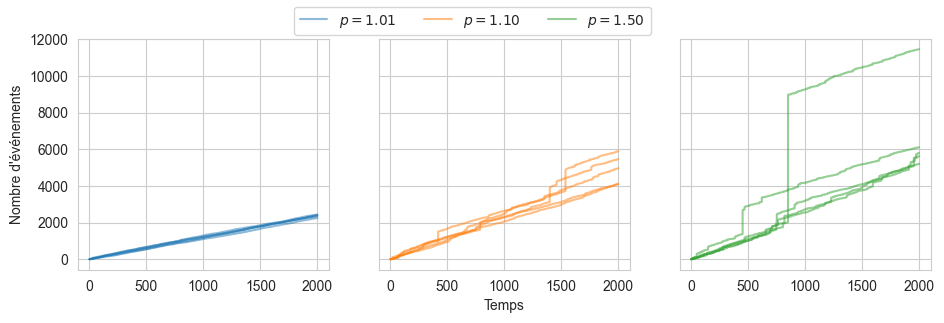

In [140]:
pl = [1.01, 1.1, 1.5]

fig, axes = plt.subplots(1, 3, sharey="row", figsize=(11, 3))

for i, (p, ax) in enumerate(zip(pl, axes)):
    for j in range(5):
        label = f"$p = {p:.2f}$" if j == 0 else None
        seq = etas(t_end=2000, p=p)
        ax.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1), label=label, c=f"C{i}", alpha=0.5)

axes[0].set_ylabel("Nombre d'événements")
axes[1].set_xlabel("Temps")

fig.legend(loc="upper center", ncol=3)
plt.savefig("p_etas.png", bbox_inches="tight", dpi=150)

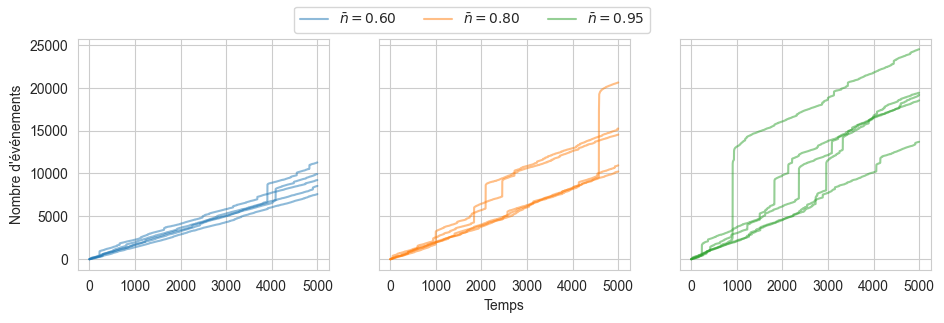

In [131]:
bar_n = [0.6, 0.8, 0.95]

fig, axes = plt.subplots(1, 3, sharey="row", figsize=(11, 3))

for i, (b, ax) in enumerate(zip(bar_n, axes)):
    for j in range(5):
        label = f"$\\bar{{n}} = {b:.2f}$" if j == 0 else None
        seq = etas(t_end=5000, bar_n=b)
        ax.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1), label=label, c=f"C{i}", alpha=0.5)

axes[0].set_ylabel("Nombre d'événements")
axes[1].set_xlabel("Temps")

fig.legend(loc="upper center", ncol=3)
plt.savefig("bar_n_etas.png", bbox_inches="tight", dpi=150)

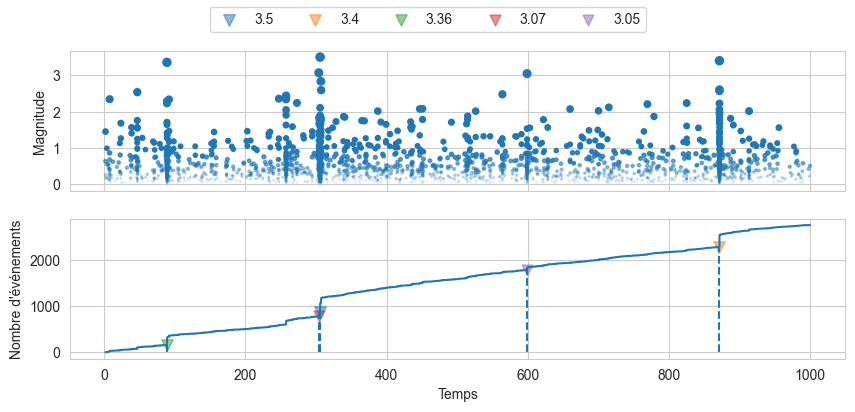

In [89]:
# We can visualize an ETAS sequence this way.

seq = etas(t_end=1000)
frame = to_frame(seq)

high_mags_idx = frame.magnitude.sort_values(ascending=False).index[:5]

fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex="col")

axes[0].scatter(frame.time, frame.magnitude, s=frame.magnitude * 10,
                alpha=np.clip(frame.magnitude, 0, 1))
axes[1].plot(frame.time, frame.index + 1)
for idx in high_mags_idx:
    t = frame.time.iloc[idx]
    m = frame.magnitude.iloc[idx]
    axes[1].vlines(t, 0, idx, cmap=plt.cm.binary, linestyle="--")
    axes[1].scatter(t, idx, s=m * 20, alpha=0.5, label=round(m, 2), marker="v")

axes[1].set_xlabel("Temps")
axes[0].set_ylabel("Magnitude")
axes[1].set_ylabel("Nombre d'événements")

fig.legend(loc="upper center", ncol=len(high_mags_idx))
plt.savefig("etas_viz.png", dpi=150, bbox_inches="tight")
plt.show()

### Training models

In [11]:
# The dataset is used by Oleksandr Shchur in his toy example.

inter_times, seq_lengths, t_end = pickle.load(open("dataset_1.pkl", "rb"))
model = Model(C=32, dist=Weibull, R=1)
history = model.fit(inter_times, seq_lengths, t_end, 200, verbose=1)
model.save("model_1.pkl")

Loss at epoch    1:    1.052
Loss at epoch   10:    0.825
Loss at epoch   20:    0.799
Loss at epoch   30:    0.789
Loss at epoch   40:    0.780
Loss at epoch   50:    0.774
Loss at epoch   60:    0.769
Loss at epoch   70:    0.766
Loss at epoch   80:    0.763
Loss at epoch   90:    0.755
Loss at epoch  100:    0.743
Loss at epoch  110:    0.734
Loss at epoch  120:    0.731
Loss at epoch  130:    0.726
Loss at epoch  140:    0.724
Loss at epoch  150:    0.722
Loss at epoch  160:    0.719
Loss at epoch  170:    0.721
Loss at epoch  180:    0.718
Loss at epoch  190:    0.719
Loss at epoch  200:    0.718


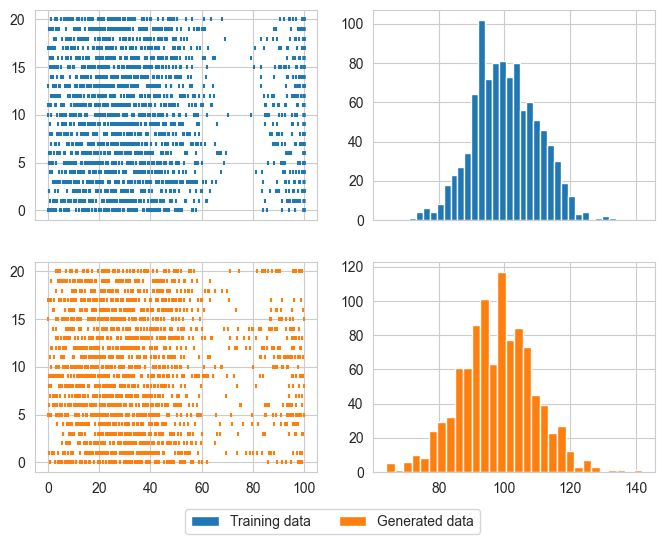

In [12]:
fig, axes = plt.subplot_mosaic([["top", "right"], ["bottom", "right"]],
                               figsize=(13, 5))
for i, seq in enumerate(arrival_times):
    t = seq[:seq_lengths[i]]
    axes["top"].scatter(
        t, np.ones_like(t) * i, marker="|", s=50, c="C0")
    if i == 5: break
left_patch = mpatches.Patch(color="C0", label="Données d'entraînement")
for i, seq in enumerate(gen_arrival_times):
    t = seq[:gen_seq_lengths[i]]
    axes["bottom"].scatter(
        t, np.ones_like(t) * i, marker="|", s=50, c="C1")
    if i == 5: break
right_patch = mpatches.Patch(color="C1", label="Données générées")
axes["right"].hist(gen_seq_lengths, bins=30, alpha=0.4)
axes["right"].axvline(x=np.mean(seq_lengths), color="black", linestyle="--",
                      label="Moyenne sur les données d'entraînement")
axes["right"].legend(loc="upper left")
axes["top"].sharex(axes["bottom"])
axes["bottom"].set_xlabel("Temps")
axes["right"].set_xlabel("Nombre d'événements générés")
fig.legend(handles=[left_patch, right_patch], loc="upper center", ncol=2)
plt.savefig("gen_data.png", dpi=150, bbox_inches="tight")

In [ ]:
inter_times, seq_lengths, t_end = pickle.load(open("dataset_1.pkl", "rb"))
model = Model(C=32, dist=Gamma, R=3, learning_rate=1e-2)
history = model.fit(inter_times, seq_lengths, t_end, 250, verbose=1)

arrival_times = np.cumsum(inter_times, -1)
gen_arrival_times, gen_seq_lengths = model.generate(1000, t_end)

fig, axes = plt.subplot_mosaic([["top", "right"], ["bottom", "right"]],
                               figsize=(13, 5))
for i, seq in enumerate(arrival_times):
    t = seq[:seq_lengths[i]]
    axes["top"].scatter(
        t, np.ones_like(t) * i, marker="|", s=50, c="C0")
    if i == 5: break
left_patch = mpatches.Patch(color="C0", label="Données d'entraînement")
for i, seq in enumerate(gen_arrival_times):
    t = seq[:gen_seq_lengths[i]]
    axes["bottom"].scatter(
        t, np.ones_like(t) * i, marker="|", s=50, c="C1")
    if i == 5: break
right_patch = mpatches.Patch(color="C1", label="Données générées")
axes["right"].hist(gen_seq_lengths, bins=30, alpha=0.4)
axes["right"].axvline(x=np.mean(seq_lengths), color="black", linestyle="--", label="Moyenne sur les données d'entraînement")
axes["right"].legend(loc="upper left")
axes["top"].sharex(axes["bottom"])
axes["bottom"].set_xlabel("Temps")
axes["right"].set_xlabel("Nombre d'événements générés")
fig.legend(handles=[left_patch, right_patch], loc="upper center", ncol=2)
plt.savefig("gen_data.png", dpi=150, bbox_inches="tight")

In [102]:
# Generate a dummy dataset with inter-arrival times distributed according
# to a Weibull distribution.

b = 2
k = 3
arrival_times = np.cumsum(Weibull(b, k).sample([100, 250]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

model = Model(C=32, dist=Weibull, R=1)
history = model.fit(inter_times, seq_lengths, t_end, epochs=250,
                    return_distributions=True, verbose=1)
model.save("model_2.pkl")
pickle.dump((inter_times, seq_lengths, t_end), open("dataset_2.pkl", "wb"))

Loss at epoch    1:    1.569
Loss at epoch   10:    0.376
Loss at epoch   20:    0.151
Loss at epoch   30:    0.125
Loss at epoch   40:    0.100
Loss at epoch   50:    0.095
Loss at epoch   60:    0.094
Loss at epoch   70:    0.092
Loss at epoch   80:    0.091
Loss at epoch   90:    0.090
Loss at epoch  100:    0.089
Loss at epoch  110:    0.089
Loss at epoch  120:    0.088
Loss at epoch  130:    0.088
Loss at epoch  140:    0.087
Loss at epoch  150:    0.087
Loss at epoch  160:    0.087
Loss at epoch  170:    0.086
Loss at epoch  180:    0.086
Loss at epoch  190:    0.086
Loss at epoch  200:    0.085
Loss at epoch  210:    0.085
Loss at epoch  220:    0.085
Loss at epoch  230:    0.085
Loss at epoch  240:    0.085
Loss at epoch  250:    0.085


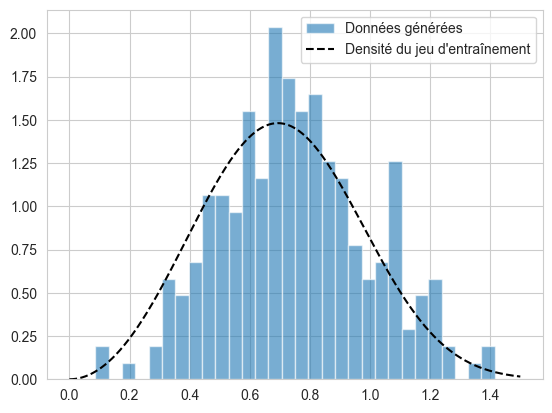

In [105]:
# Load and visualize.

model = Model.load("model_2.pkl")
inter_times, seq_lengths, t_end = pickle.load(open("dataset_2.pkl", "rb"))
arrival_times = np.cumsum(inter_times, -1)
gen_arrival_times, gen_seq_lengths = model.generate(1000, t_end)

plt.hist(np.diff(gen_arrival_times[0], prepend=0),
         density=True, bins=30, alpha=0.6, label="Données générées")
x = np.linspace(0, 1.5, 1000)
plt.plot(x, Weibull(b, k).prob(x), c="black",
         linestyle="--", label="Densité du jeu d'entraînement")
plt.legend(loc="upper right", ncol=1)
plt.savefig("inter_times_density_training.png", bbox_inches="tight", dpi=150)

### Parameters convergence

In [74]:
# We train a model on a dummy dataset and get the distributions back on
# each epoch in a history object.

b = 2
k = 3
arrival_times = np.cumsum(Weibull(b, k).sample([100, 150]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

model = Model(C=32, dist=Weibull, R=1)
history = model.fit(inter_times, seq_lengths, t_end, epochs=100,
                    return_distributions=True, verbose=1)

Loss at epoch    1:    1.656
Loss at epoch   10:    0.685
Loss at epoch   20:    0.209
Loss at epoch   30:    0.133
Loss at epoch   40:    0.119
Loss at epoch   50:    0.114
Loss at epoch   60:    0.111
Loss at epoch   70:    0.110
Loss at epoch   80:    0.109
Loss at epoch   90:    0.108
Loss at epoch  100:    0.108


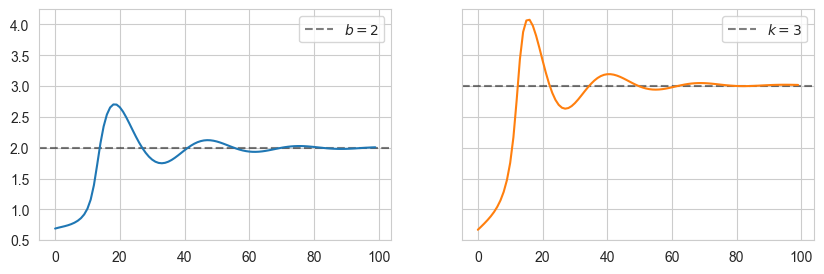

In [75]:
# Visualize the convergence.

distributions = history["distributions"]
params = [d.params[1] for d in distributions]
params = np.squeeze(np.stack(params, 0), -2)

fig, axes = plt.subplots(1, 2, sharey="row", figsize=(10, 3))

axes[0].axhline(y=b, label=f"$b = {b}$", c="black", linestyle="--", alpha=0.5)
axes[0].legend()
axes[1].axhline(y=k, label=f"$k = {k}$", c="black", linestyle="--", alpha=0.5)
axes[1].legend()

num_epochs = len(distributions)
last_idx = enumerate(seq_lengths)

b_mean_per_epoch = [np.mean(params[i, ..., 0][range(100), seq_lengths])
                    for i in range(num_epochs)]
axes[0].plot(range(num_epochs), b_mean_per_epoch, c="C0")

k_mean_per_epoch = [np.mean(params[i, ..., 1][range(100), seq_lengths])
                      for i in range(num_epochs)]
axes[1].plot(range(num_epochs), k_mean_per_epoch, c="C1")

plt.savefig("images/weibull_cvg.png", bbox_inches="tight", dpi=150)
plt.show()

In [69]:
# We do the same as before with data distributed by a Gamma distribution.

alpha = 1
beta = 3
arrival_times = np.cumsum(tfd.Gamma(alpha, beta).sample([300, 150]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

model = Model(C=32, dist=Gamma, R=1)
history = model.fit(inter_times, seq_lengths, t_end, epochs=100,
                    return_distributions=True, verbose=1)

Loss at epoch    1:    0.552
Loss at epoch   10:   -0.252
Loss at epoch   20:   -0.220
Loss at epoch   30:   -0.259
Loss at epoch   40:   -0.269
Loss at epoch   50:   -0.274
Loss at epoch   60:   -0.275
Loss at epoch   70:   -0.277
Loss at epoch   80:   -0.279
Loss at epoch   90:   -0.279
Loss at epoch  100:   -0.280


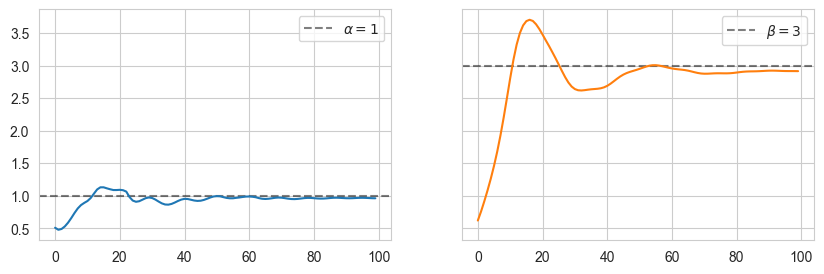

In [72]:

distributions = history["distributions"]
params = [d.params[1] for d in distributions]
params = np.squeeze(np.stack(params, 0), -2)

fig, axes = plt.subplots(1, 2, sharey="row", figsize=(10, 3))

axes[0].axhline(y=alpha, label=f"$\\alpha = {alpha}$", linestyle="--", c="black", alpha=0.5)
axes[0].legend()
axes[1].axhline(y=beta, label=f"$\\beta = {beta}$", linestyle="--", c="black", alpha=0.5)
axes[1].legend()

num_epochs = len(distributions)

alpha_mean_per_epoch = [np.mean(params[i, ..., 0][range(300), seq_lengths])
                    for i in range(num_epochs)]
axes[0].plot(range(num_epochs), alpha_mean_per_epoch, c="C0")

beta_mean_per_epoch = [np.mean(params[i, ..., 1][range(300), seq_lengths])
                      for i in range(num_epochs)]
axes[1].plot(range(num_epochs), beta_mean_per_epoch, c="C1")

plt.savefig("images/gamma_cvg.png", bbox_inches="tight")

plt.show()

Loss at epoch    1:    1.186
Loss at epoch   10:    0.842
Loss at epoch   20:    0.760
Loss at epoch   30:    0.736
Loss at epoch   40:    0.728
Loss at epoch   50:    0.727
Loss at epoch   60:    0.727
Loss at epoch   70:    0.726
Loss at epoch   80:    0.726
Loss at epoch   90:    0.726
Loss at epoch  100:    0.725


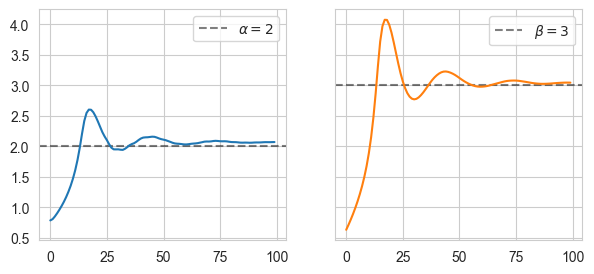

In [311]:
# We do the same as before with data distributed by a Gamma distribution.

alpha = 2
beta = 3
arrival_times = np.cumsum(tfd.Gamma(alpha, beta).sample([300, 250]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

model = Model(C=32, dist=Gamma, R=1)
history = model.fit(inter_times, seq_lengths, t_end, epochs=100,
                    return_distributions=True, verbose=1)

distributions = history["distributions"]
params = [d.params[1] for d in distributions]
params = np.squeeze(np.stack(params, 0), -2)

fig, axes = plt.subplots(1, 2, sharey="row", figsize=(7, 3))

axes[0].axhline(y=alpha, label=f"$\\alpha = {alpha}$", linestyle="--", c="black", alpha=0.5)
axes[0].legend()
axes[1].axhline(y=beta, label=f"$\\beta = {beta}$", linestyle="--", c="black", alpha=0.5)
axes[1].legend()

num_epochs = len(distributions)
last_idx = list(enumerate(seq_lengths))

alpha_mean_per_epoch = [np.mean(params[i, ..., 0][last_idx])
                    for i in range(num_epochs)]
axes[0].plot(range(num_epochs), alpha_mean_per_epoch, c="C0")

beta_mean_per_epoch = [np.mean(params[i, ..., 1][last_idx])
                      for i in range(num_epochs)]
axes[1].plot(range(num_epochs), beta_mean_per_epoch, c="C1")

plt.show()

### Training with ETAS sequences

In [182]:
seqs, (inter_times, magnitudes, seq_lengths), t_end = generate_dataset(
    batch_size=100, max_len=250, t_end=100)

In [183]:
model = Model(C=32, dist=Weibull, R=32, dropout=True, strategy="log_tau")
history = model.fit(inter_times, seq_lengths, t_end, 250,
                    magnitudes, verbose=1)

Loss at epoch    1:  -10.431
Loss at epoch   10:  -15.150
Loss at epoch   20:  -15.399
Loss at epoch   30:  -15.682
Loss at epoch   40:  -15.931
Loss at epoch   50:  -16.141
Loss at epoch   60:  -16.346
Loss at epoch   70:  -16.537
Loss at epoch   80:  -16.721
Loss at epoch   90:  -16.862
Loss at epoch  100:  -16.968
Loss at epoch  110:  -17.089
Loss at epoch  120:  -17.158
Loss at epoch  130:  -17.242
Loss at epoch  140:  -17.307
Loss at epoch  150:  -17.345
Loss at epoch  160:  -17.384
Loss at epoch  170:  -17.443
Loss at epoch  180:  -17.484
Loss at epoch  190:  -17.527
Loss at epoch  200:  -17.549
Loss at epoch  210:  -17.570
Loss at epoch  220:  -17.599
Loss at epoch  230:  -17.631
Loss at epoch  240:  -17.642
Loss at epoch  250:  -17.656


### Generation

In [184]:
generated_data, seq_lengths = model.generate(10, np.mean(t_end))

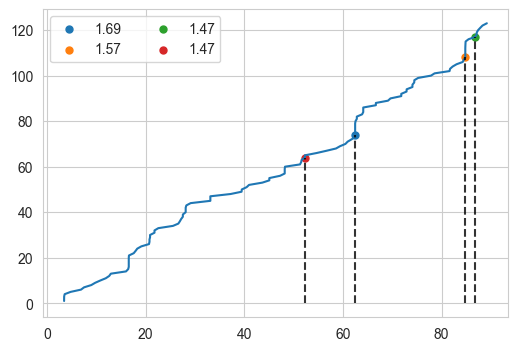

In [270]:
plot_etas_seq(get_seq(generated_data, seq_lengths, 4), 4)

### The next inter-arrival time distribution

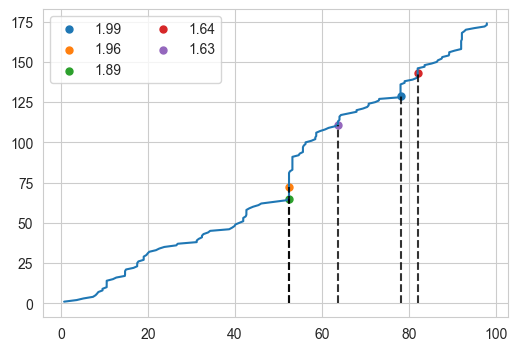

In [264]:
seq = to_frame(etas(t_end=100))
plot_etas_seq(seq, 5)

In [265]:
idx = seq.magnitude.sort_values(ascending=False).iloc[:5].sort_index().index
first_mag_idx = idx[0]
print(idx)

Index([64, 71, 110, 128, 142], dtype='int64')


In [266]:
seq.iloc[:first_mag_idx + 1].tail()

,time,magnitude,parent
60,45.413458,0.171143,-1.0
61,46.049331,0.304119,-1.0
62,48.865585,0.613940,-1.0
63,51.755107,0.618333,-1.0
64,52.432212,1.891605,-1.0


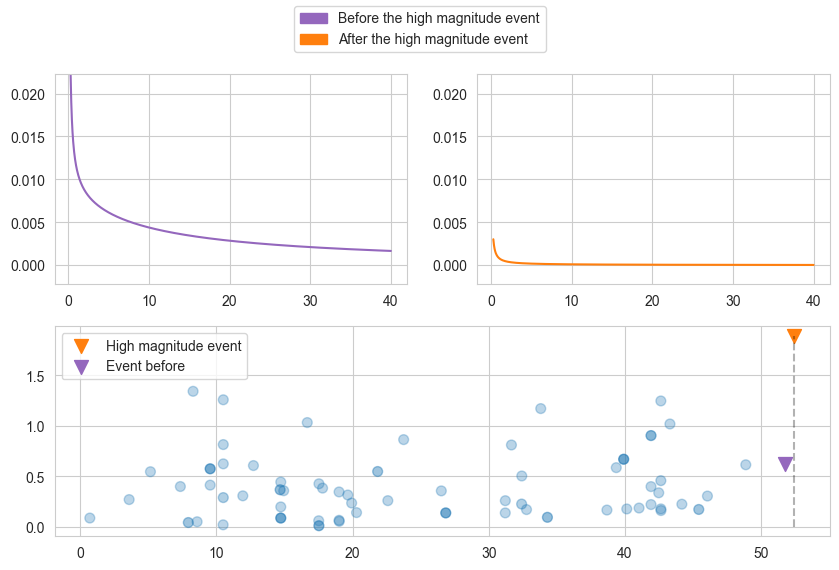

In [267]:
fig, axes = plt.subplot_mosaic([["left", "right"], ["bottom", "bottom"]],
                               figsize=(11, 6))
# fig.subplots_adjust()

subset = seq.iloc[:first_mag_idx + 1]
t = subset.time.to_numpy()
m = subset.magnitude.to_numpy()

dist_0 = ETAS(t[:-1], m[:-1])
pdf_0 = dist_0.density
x = np.linspace(0.3, 40, 1000)
axes["left"].plot(x, pdf_0(x), c="C0")
axes["left"].set_ylim(-pdf_0(x[0]) * 0.1, pdf_0(x[0]))
axes["left"].set_ylabel("Densité de probabilité")
left_patch = mpatches.Patch(color="C0", label="Avant")

dist_1 = ETAS(t, m)
pdf_1 = dist_1.density
axes["right"].plot(x, pdf_1(x), c="C1")
right_patch = mpatches.Patch(color="C1", label="Après")

axes["right"].sharex(axes["left"])
axes["right"].sharey(axes["left"])

n_before = 100
size = 50
size_le = size * 2
marker = "v"

axes["bottom"].scatter(t[-n_before:-2], m[-n_before:-2], s=size, alpha=np.maximum(0.3, m[-30:-2] / np.max(m)))
axes["bottom"].vlines(t[-1], 0, m[-1], linestyle="--", colors="black", alpha=0.3)
axes["bottom"].scatter(t[-1], m[-1], label="Grande magnitude", c="C1", s=size_le, marker=marker)
axes["bottom"].scatter(t[-2], m[-2], label="Événement précédent", c="C0", s=size_le, marker=marker)
axes["bottom"].legend(loc="upper left")
axes["bottom"].set_ylabel("Magnitude")
axes["bottom"].set_xlabel("Temps")

fig.legend(handles=[left_patch, right_patch], loc="upper center", ncol=2)

plt.savefig("etas_dist.png", bbox_inches="tight", dpi=150)

### Predictions

In [315]:
seqs, (inter_times, magnitudes, seq_lengths), t_end = generate_dataset(
    100, t_end=100, max_len=150, verbose=True)

Generating sequences:  100/100


In [319]:
model = Model(C=32, dist=Weibull, R=10, dropout=True, strategy="log_tau")
history = model.fit(inter_times, seq_lengths, t_end, 200, magnitudes)

Loss at epoch    1:   -8.568
Loss at epoch   10:  -13.926
Loss at epoch   20:  -14.282
Loss at epoch   30:  -14.563
Loss at epoch   40:  -14.748
Loss at epoch   50:  -14.921
Loss at epoch   60:  -15.078
Loss at epoch   70:  -15.293
Loss at epoch   80:  -15.478
Loss at epoch   90:  -15.617
Loss at epoch  100:  -15.770
Loss at epoch  110:  -15.854
Loss at epoch  120:  -15.979
Loss at epoch  130:  -16.054
Loss at epoch  140:  -16.097
Loss at epoch  150:  -16.157
Loss at epoch  160:  -16.223
Loss at epoch  170:  -16.271
Loss at epoch  180:  -16.318
Loss at epoch  190:  -16.338
Loss at epoch  200:  -16.351


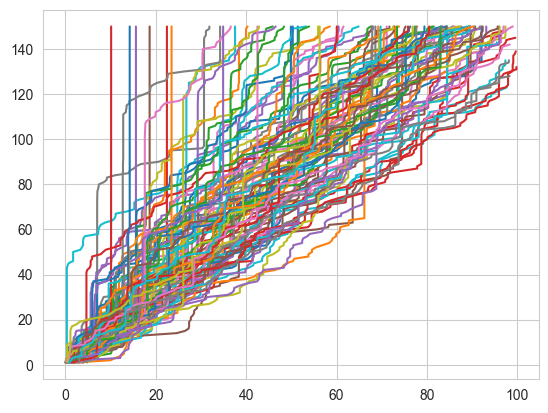

In [337]:
plot_seqs(seqs)

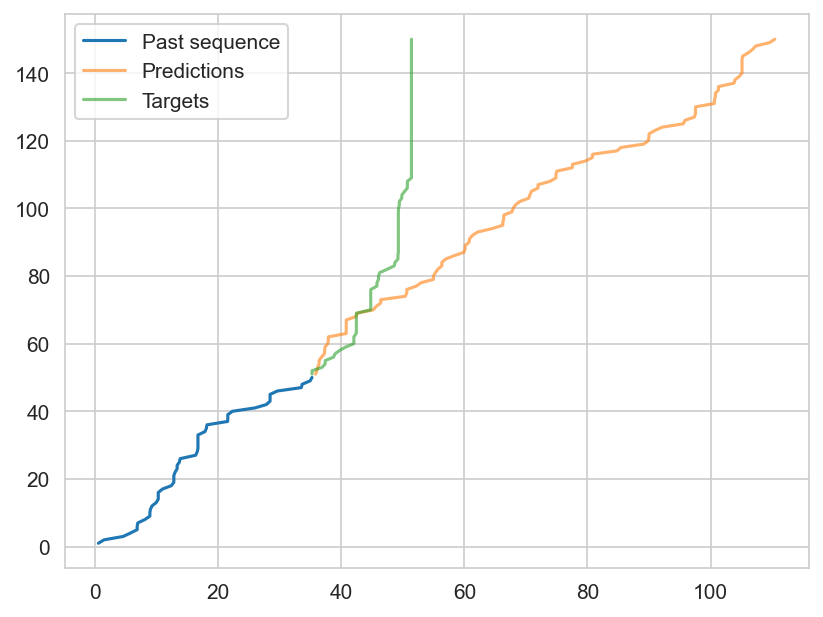

In [382]:
seq = seqs[0]
new_seq = predict_and_plot(model, seq, n_before=100)

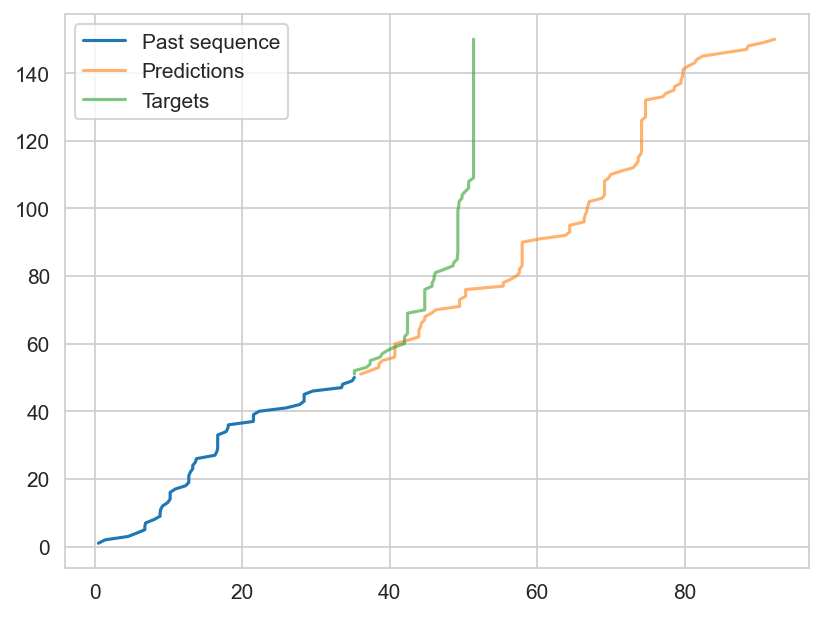

In [387]:
seq = seqs[1]
new_seq = predict_and_plot(model, seq, n_before=100)

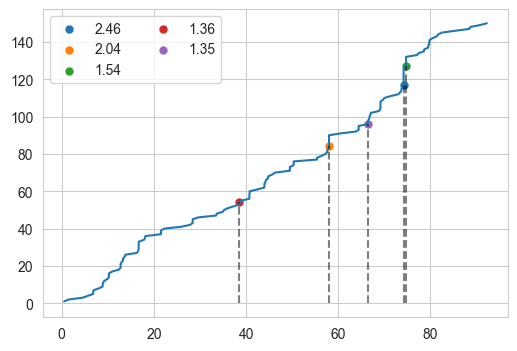

In [389]:
plot_etas_seq(to_frame(new_seq), 5)

### Distributions comparisons

In [430]:
seqs, (inter_times, magnitudes, seq_lengths), t_end = generate_dataset(
    100, t_end=100, max_len=150, verbose=True)

model = Model(C=32, dist=Gamma, R=1, dropout=True, strategy="log_tau")
history = model.fit(inter_times, seq_lengths, t_end, 200, magnitudes)

Generating sequences:  100/100
Loss at epoch    1:   25.658
Loss at epoch   10:  -17.388
Loss at epoch   20:  -19.324
Loss at epoch   30:  -19.891
Loss at epoch   40:  -20.247
Loss at epoch   50:  -20.424
Loss at epoch   60:  -20.656
Loss at epoch   70:  -20.787
Loss at epoch   80:  -20.912
Loss at epoch   90:  -20.945
Loss at epoch  100:  -21.043
Loss at epoch  110:  -21.064
Loss at epoch  120:  -21.097
Loss at epoch  130:  -21.099
Loss at epoch  140:  -21.134
Loss at epoch  150:  -21.149
Loss at epoch  160:  -21.182
Loss at epoch  170:  -21.201
Loss at epoch  180:  -21.237
Loss at epoch  190:  -21.212
Loss at epoch  200:  -21.230


In [431]:
seq = seqs[0]
to_frame(seq).magnitude.sort_values(ascending=False).iloc[:5]

61     2.354049
4      1.900607
128    1.854111
11     1.852076
64     1.427913
Name: magnitude, dtype: float64

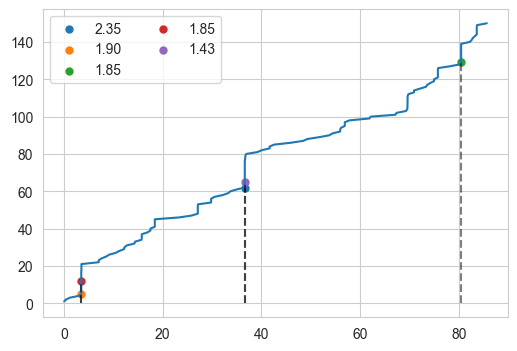

In [469]:
plot_etas_seq(to_frame(seq), 5, dpi=100)

In [439]:
to_frame(seq).iloc[50:70]

,time,magnitude,parent
50,27.101719,0.060733,49.0
51,27.101719,0.455459,49.0
52,27.132039,0.142672,-1.0
53,29.805070,0.394369,-1.0
54,29.805070,0.218809,53.0
55,29.805070,0.112725,53.0
56,30.460664,0.402462,-1.0
57,32.183299,0.032729,-1.0
58,33.248380,0.198475,-1.0
59,33.728401,0.141315,-1.0


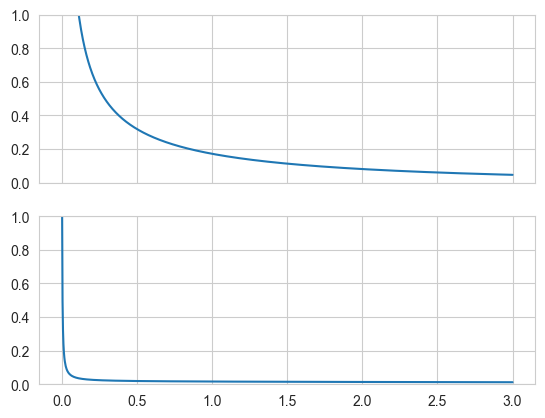

In [466]:
sub_seq = seq[:61]
t = sub_seq[:, 0]
m = sub_seq[:, 1]

recast_dist = model.predict(t, m, 1, True)[1][0]
etas_dist = ETAS(t, m)

fig, axes = plt.subplots(2, 1, sharex="col", sharey="col")
x = np.linspace(0, 3, 1000)
axes[0].plot(x, recast_dist.prob(x))
axes[1].plot(x, etas_dist.prob(x))
axes[1].set_ylim([0, 1])

plt.show()

In [468]:
recast_dist.dist.params

<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[0.06556592, 0.6788161 ]]], dtype=float32)>

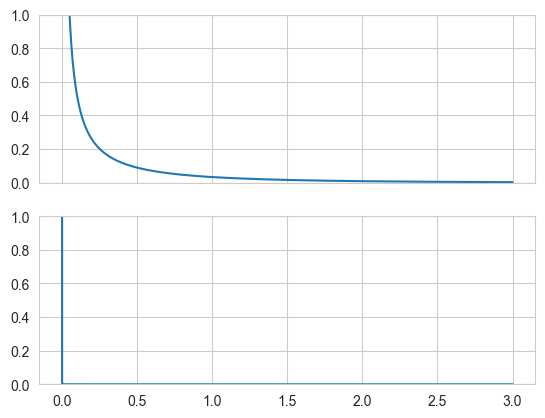

In [467]:
cmp_dist(model, seq, 20)

### Loading and visualization

In [7]:
model = Model.load("model_5.pkl")
seq = pickle.load(open("seq_2.pkl", "rb"))
seq.shape

(70000, 3)

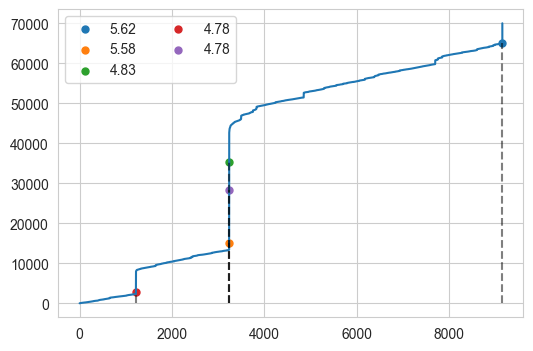

In [8]:
plot_etas_seq(to_frame(seq), 5)

In [28]:
sub_seq = seq[:10000]

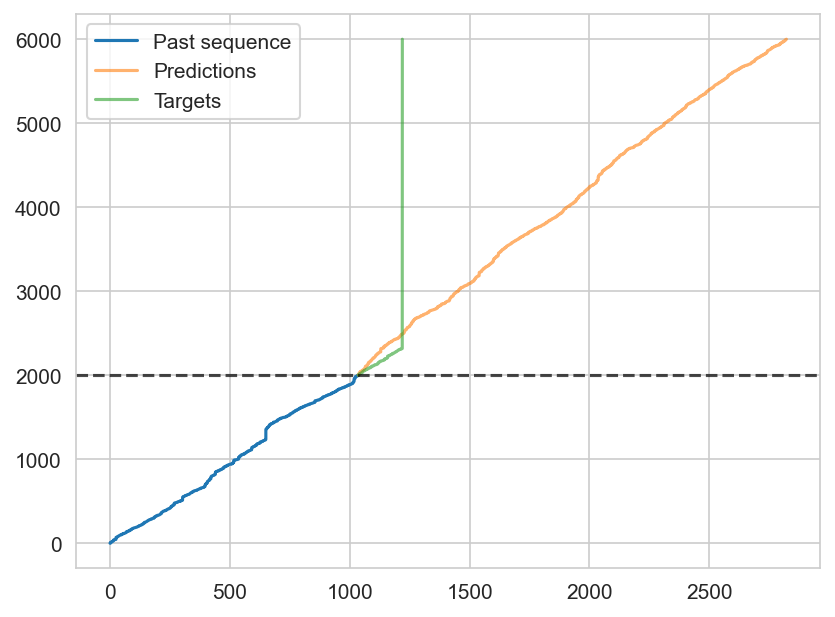

In [36]:
new_seq = predict_and_plot(model, sub_seq, 8000, 4000, dpi=150)

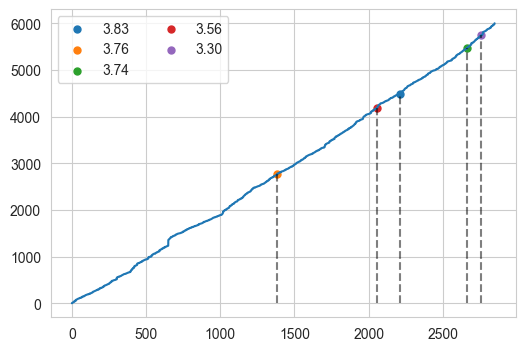

In [33]:
plot_etas_seq(to_frame(new_seq), 5)

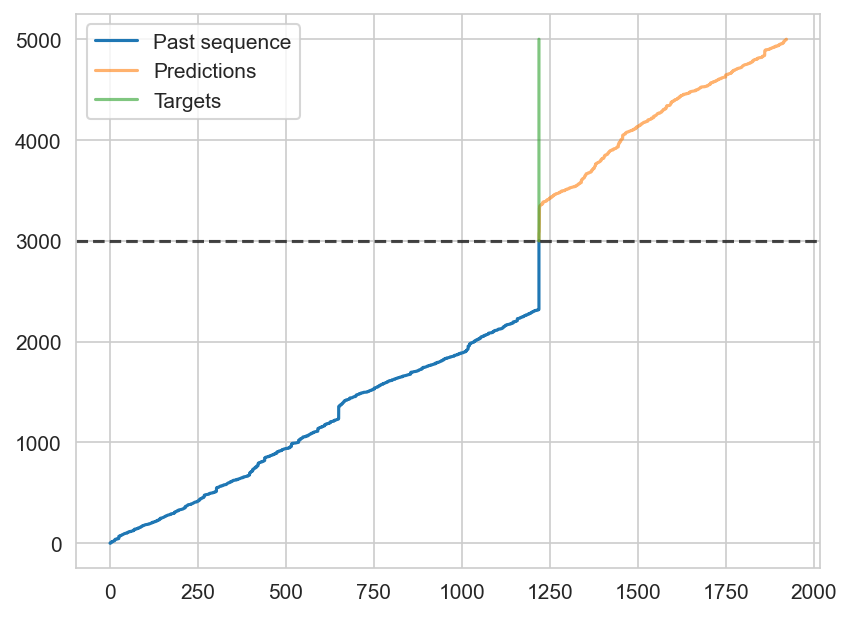

In [35]:
new_seq = predict_and_plot(model, sub_seq, 7000, 2000, dpi=150)

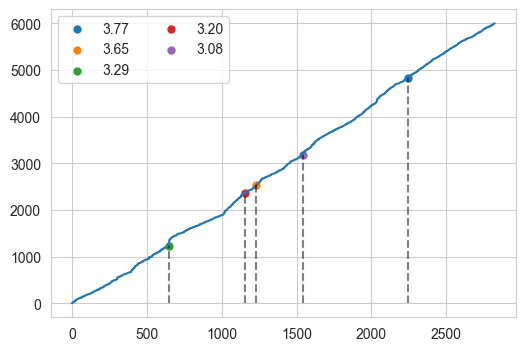

In [37]:
plot_etas_seq(to_frame(new_seq), 5)

### ETAS log-likelihood

In [54]:
seqs, (inter_times, magnitudes, seq_lengths), t_end = generate_dataset(
    batch_size=1, t_end=300
)

In [66]:
etas_log_like = log_likelihood(seqs[0], t_end)

In [62]:
model = Model(R=10, learning_rate=1e-2, strategy="log_tau")
history = model.fit(inter_times, seq_lengths,
                    t_end, 500, magnitudes, verbose=1)

Loss at epoch    1:  -14.560
Loss at epoch   10:  -23.442
Loss at epoch   20:  -25.066
Loss at epoch   30:  -25.528
Loss at epoch   40:  -25.846
Loss at epoch   50:  -26.045
Loss at epoch   60:  -26.188
Loss at epoch   70:  -26.313
Loss at epoch   80:  -26.424
Loss at epoch   90:  -26.526
Loss at epoch  100:  -26.621
Loss at epoch  110:  -26.706
Loss at epoch  120:  -26.781
Loss at epoch  130:  -26.864
Loss at epoch  140:  -26.944
Loss at epoch  150:  -27.023
Loss at epoch  160:  -27.108
Loss at epoch  170:  -27.176
Loss at epoch  180:  -27.264
Loss at epoch  190:  -27.347
Loss at epoch  200:  -27.436
Loss at epoch  210:  -27.496
Loss at epoch  220:  -27.539
Loss at epoch  230:  -27.672
Loss at epoch  240:  -27.777
Loss at epoch  250:  -27.851
Loss at epoch  260:  -27.914
Loss at epoch  270:  -27.983
Loss at epoch  280:  -28.070
Loss at epoch  290:  -28.179
Loss at epoch  300:  -28.252
Loss at epoch  310:  -28.323
Loss at epoch  320:  -28.406
Loss at epoch  330:  -28.391
Loss at epoch 

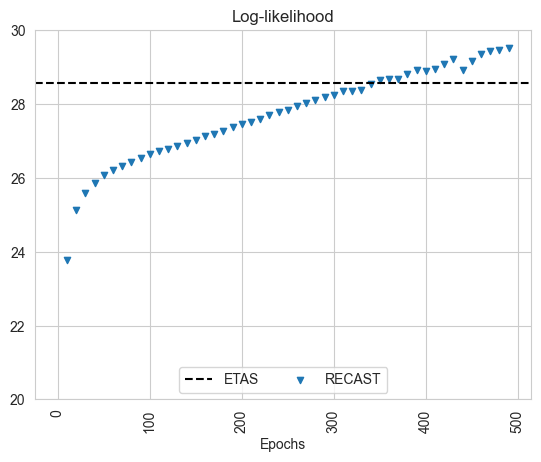

In [91]:
recast_log_like = -np.array(history["loss"])[::10]
x = range(len(recast_log_like))

plt.axhline(y=etas_log_like, linestyle="--", c="black", label="ETAS")
plt.scatter(x, recast_log_like, label="RECAST", marker="v", s=20)
plt.legend(ncol=2, loc="lower center")
plt.title("Log-likelihood")
plt.ylim(20, 30)
plt.xticks(ticks=range(0, 51, 10), labels=range(0, 501, 100), rotation=90)
plt.xlabel("Epochs")
plt.show()

In [36]:
seqs, (inter_times, magnitudes, seq_lengths), t_end = generate_dataset(
    batch_size=1, t_end=600
)
print(seqs[0].shape)
etas_log_like = log_likelihood(seqs[0], t_end)
print(etas_log_like)
model = Model(R=10, learning_rate=1e-3, strategy="log_tau")
history = model.fit(inter_times, seq_lengths,
                    t_end, 500, magnitudes, verbose=1)


(1324, 3)
11.154568124696503
Loss at epoch    1:   -5.925
Loss at epoch   10:   -7.179
Loss at epoch   20:   -8.286
Loss at epoch   30:   -9.132
Loss at epoch   40:   -9.670
Loss at epoch   50:   -9.959
Loss at epoch   60:  -10.152
Loss at epoch   70:  -10.309
Loss at epoch   80:  -10.419
Loss at epoch   90:  -10.505
Loss at epoch  100:  -10.573
Loss at epoch  110:  -10.631
Loss at epoch  120:  -10.683
Loss at epoch  130:  -10.732
Loss at epoch  140:  -10.776
Loss at epoch  150:  -10.816
Loss at epoch  160:  -10.852
Loss at epoch  170:  -10.884
Loss at epoch  180:  -10.914
Loss at epoch  190:  -10.942
Loss at epoch  200:  -10.967
Loss at epoch  210:  -10.991
Loss at epoch  220:  -11.013
Loss at epoch  230:  -11.035
Loss at epoch  240:  -11.056
Loss at epoch  250:  -11.077
Loss at epoch  260:  -11.097
Loss at epoch  270:  -11.116
Loss at epoch  280:  -11.135
Loss at epoch  290:  -11.153
Loss at epoch  300:  -11.171
Loss at epoch  310:  -11.188
Loss at epoch  320:  -11.205
Loss at epoch

In [141]:
seqs, (inter_times, magnitudes, seq_lengths), t_end = generate_dataset(
    100, t_end=100, max_len=250, verbose=True)

model = Model(C=32, dist=Weibull, R=3, dropout_rate=.4, strategy="log_tau")
history = model.fit(inter_times, seq_lengths, t_end, 200, magnitudes)

Generating sequences:  100/100
Loss at epoch    1:  -16.172
Loss at epoch   10:  -20.675
Loss at epoch   20:  -21.628
Loss at epoch   30:  -22.125
Loss at epoch   40:  -22.469
Loss at epoch   50:  -22.667
Loss at epoch   60:  -22.852
Loss at epoch   70:  -23.005
Loss at epoch   80:  -23.163
Loss at epoch   90:  -23.316
Loss at epoch  100:  -23.392
Loss at epoch  110:  -23.520
Loss at epoch  120:  -23.627
Loss at epoch  130:  -23.728
Loss at epoch  140:  -23.818
Loss at epoch  150:  -23.861
Loss at epoch  160:  -23.939
Loss at epoch  170:  -23.977
Loss at epoch  180:  -24.074
Loss at epoch  190:  -24.080
Loss at epoch  200:  -24.140


In [147]:
np.mean(seq_lengths)

175.549

In [148]:
np.mean(t_end)

91.56044602846956

In [149]:
gen_data, seq_lengths = model.generate(1000, 100)

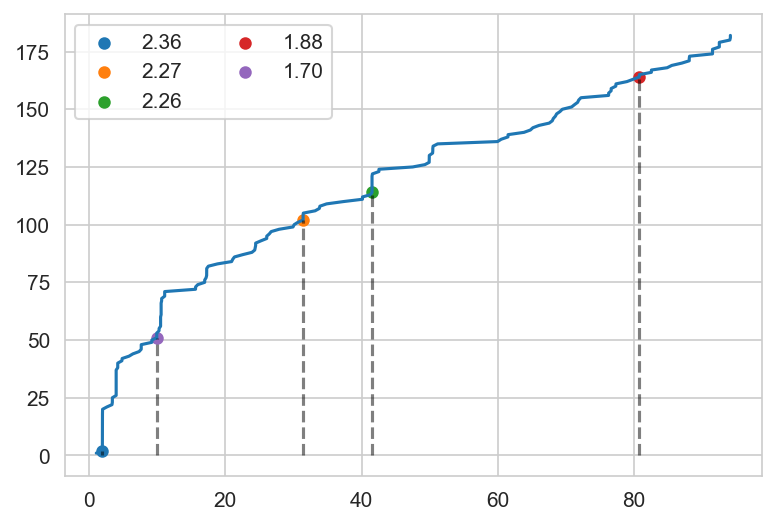

In [150]:
plot_etas_seq(to_frame(gen_data[0][:seq_lengths[0]]), 5, dpi=150)

In [151]:
seq = etas(t_end=np.mean(t_end))

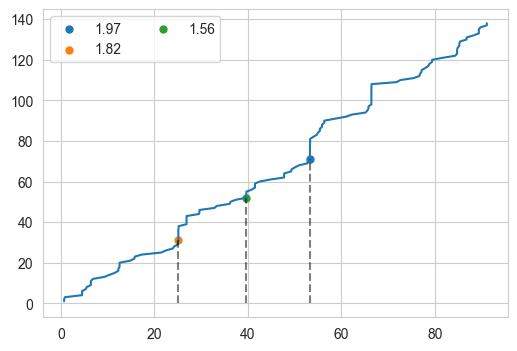

In [153]:
plot_etas_seq(to_frame(seq), 3)

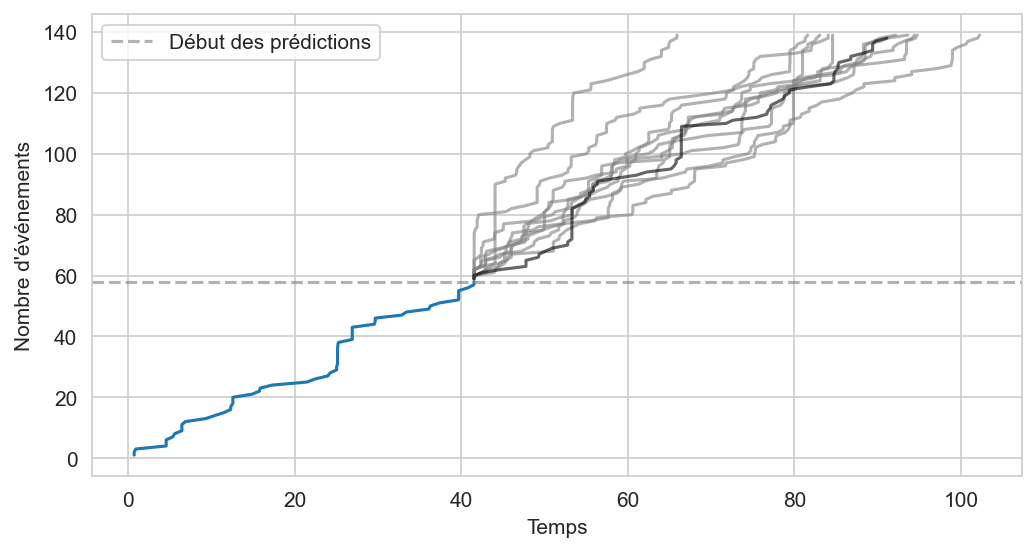

In [164]:
n_before = 80
n_after = 80
n_preds = n_after if n_after else n_before

past_seq = seq[:-n_before]

fig, ax = plt.subplots(dpi=150, figsize=(8, 4))

t = past_seq[:, 0]
m = past_seq[:, 1]
for i in range(10):
    preds = model.predict(t, m, n_preds)
    t_preds = np.concatenate([[t[-1]], preds[:, 0]])
    m_preds = preds[:, 1]
    ax.plot(t_preds, t.size + cumsum(t_preds), c="gray", alpha=0.6)

seq_size = seq.shape[0]
last_idx_target = min(seq_size - 1, seq_size - n_before + n_preds)
t_targets = seq[-n_before - 1:last_idx_target, 0]

ax.plot(t, cumsum(t))
ax.plot(t_targets, t.size + cumsum(t_targets), alpha=0.6, c="black")
ax.axhline(y=t.size, linestyle="--", c="gray", alpha=0.6, label="Début des prédictions")
ax.legend()
ax.set_xlabel("Temps")
ax.set_ylabel("Nombre d'événements")
plt.savefig("etas_preds.png", bbox_inches="tight", dpi=150)

In [165]:
to_frame(seq).magnitude.sort_values()

113    0.002410
58     0.002617
69     0.003417
116    0.007522
74     0.008158
         ...   
52     1.466719
99     1.542910
51     1.564855
30     1.816142
70     1.973301
Name: magnitude, Length: 138, dtype: float64

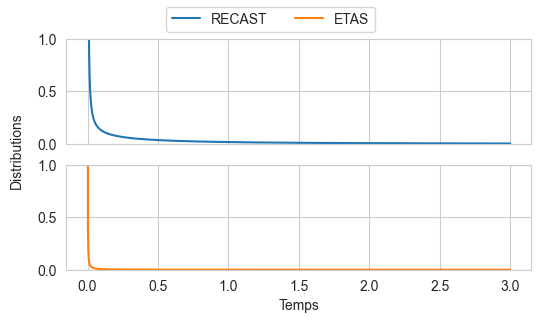

In [186]:
start = 10
sub_seq = seq[:71]
t = sub_seq[:, 0]
m = sub_seq[:, 1]

recast_dist = model.predict(t, m, 1, True)[1][0]
etas_dist = ETAS(t, m)

fig, axes = plt.subplots(2, 1, sharex="col", sharey="col", figsize=(6, 3))
x = np.linspace(0, 3, 1000)
axes[0].plot(x, recast_dist.prob(x), label="RECAST")
axes[1].plot(x, etas_dist.prob(x), label="ETAS", c="C1")
axes[1].set_ylim((0, 1))
axes[1].set_xlabel("Temps")
plt.text(-0.55, 0.8, "Distributions", rotation=90.)
fig.legend(loc="upper center", ncol=2)

plt.savefig("dist_etas_recast_2.png", dpi=150, bbox_inches="tight")

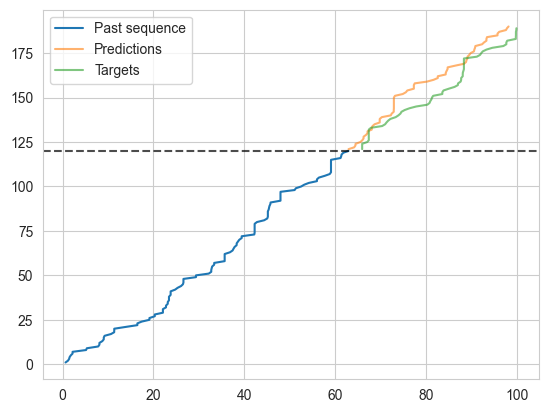

In [25]:
predict_and_plot(model, seq, 70, dpi=100);

In [24]:
preds, dists = model.predict(seq[:-1, 0], seq[:-1, 1], 1, return_distributions=True)

In [30]:
to_frame(seq).magnitude.sort_values(ascending=False)

165    1.958017
107    1.894052
46     1.761903
91     1.513953
82     1.364130
         ...   
92     0.009495
95     0.009183
177    0.007877
115    0.005707
69     0.004457
Name: magnitude, Length: 190, dtype: float64

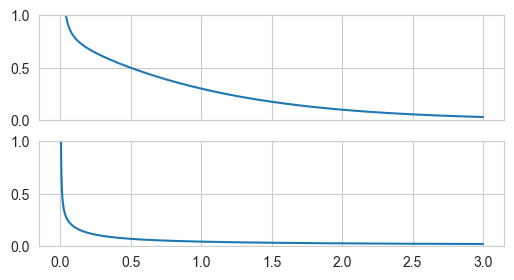

In [32]:
cmp_dist(model, seq, 165)   # Before high mag event,

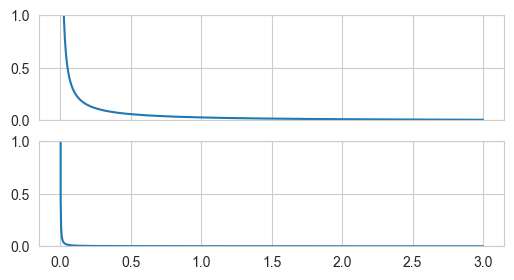

In [33]:
cmp_dist(model, seq, 166)   # After high mag event